In [270]:
import sys
import os
import pandas as pd
import csv
import requests
import random as rd
import matplotlib.pyplot as plt
import collections; collections.Callable = collections.abc.Callable
from scipy.stats import poisson
from bs4 import BeautifulSoup

In [271]:
#==============================================================================
# Gets FIFA country code and country name from Wikipedia
#==============================================================================
def get_country_code():
    content = requests.get('https://en.wikipedia.org/wiki/List_of_FIFA_country_codes').text
    parse = BeautifulSoup(content, 'lxml')
    tables = parse.find_all('table', class_='wikitable')[:4]
    country_code = []
    country_name = []
    for table in tables:
        for row in table.find_all('tr'):
            if row.find('td') is not None:
                country_name.append(row.find_all('td')[0].get_text().strip())
                country_code.append(row.find_all('td')[1].get_text().strip())
    country_code_dict = dict(zip(country_name, country_code))
    return country_code_dict

country_code_dict = get_country_code()

In [272]:
#==============================================================================
# Gets FIFA 2022 World Cup Fixtures from Wikipedia
#==============================================================================
def get_cup_fixtures(year):
    content = requests.get(f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup').text
    parse = BeautifulSoup(content, 'lxml')
    fixtures = parse.find_all('div', class_='footballbox')

    home = []
    away = []

    for match in fixtures:
        home.append(match.find('th', class_='fhome').get_text())
        away.append(match.find('th', class_='faway').get_text())

    match = {'home': home, 'away': away}
    fixes = pd.DataFrame(match)
    fixes['year'] = year
    return fixes
  
fixtures_frame = get_cup_fixtures(2022)
fixtures_frame.to_csv('./fixtures/fifa_worldcup_fixtures.csv', mode='w', index=False)

In [273]:
#==============================================================================
# Cleans up match data, keeping only teams and goals scored based on where
# to split csv file
# Adds missing matches if necessary to world cup file
#==============================================================================
def clean_matches(file, splits: list()):
    clean = []
    with open(file, encoding='utf-8') as f:
        reader = csv.reader(f)
        for line in reader:
            try:
                date = line[splits[0]].split('-')[0]
                home_team = line[splits[1]]
                away_team = line[splits[2]]
                home_score = line[splits[3]]
                away_score = line[splits[4]]
                home_code = country_code_dict[home_team]
                away_code = country_code_dict[away_team]
                if int(date) < 1998: continue
                clean.append([date, home_team, home_score, away_team, away_score, home_code, away_code])
            except: pass
    
    with open("./clean/"+"clean_"+file.split('/')[-1], 'w', newline='') as f:
        writer = csv.writer(f)
        head = ['Date', 'Home_Team', 'Home Team Goals', 'Away_Team', 'Away Team Goals', 'Home Team Initials', 'Away Team Initials']
        writer.writerow(head)
        writer.writerows(clean)

def add_matches(fn):
    f2018 = open('./data/WorldCupMatches2018.csv', 'r')
    f98 = open('./clean/clean_{}'.format(fn), 'a', newline='')

    f2018reader = csv.reader(f2018)
    f98writer = csv.writer(f98)
    next(f2018reader)
    for row in f2018reader:
        home = row[0] 
        away = row[1]
        date = row[2]
        home_score = row[3]
        away_score = row[4]
        home_code = country_code_dict[home]
        away_code = country_code_dict[away]
        f98writer.writerow([date, home, home_score, away, away_score, home_code, away_code])

    f2018.close()
    f98.close()
    

In [274]:
#==============================================================================
# Uses huge data set with every single international match since 1993
#==============================================================================
clean_matches('./data/EveryInternationalMatch.csv', [0, 1, 2, 9, 10])

In [275]:
#==============================================================================
# Using a smaller dataset with only world cup matches since 1930
#==============================================================================
#clean_matches('./data/WorldCupMatches.csv', [0, 5, 8, 6, 7, -2, -1])
clean_matches('./data/WorldCupMatches98.csv', [0, 5, 8, 6, 7, -2, -1])
add_matches('WorldCupMatches98.csv')


In [276]:
#==============================================================================
# using smaller dataset to calculate goal ratios for poisson distribution
#==============================================================================

def get_goal_ratio(file, enc='utf-8'):
    match_data = pd.read_csv(file, encoding=enc)
    home_games = match_data[['Home Team Initials', 'Home Team Goals', 'Away Team Goals']]
    away_games = match_data[['Away Team Initials', 'Home Team Goals', 'Away Team Goals']]
    home_games = home_games.rename(columns={'Home Team Initials':'Team Initials', 'Home Team Goals': 'GoalsScored', 'Away Team Goals': 'GoalsConceded'})
    away_games = away_games.rename(columns={'Away Team Initials':'Team Initials', 'Home Team Goals': 'GoalsConceded', 'Away Team Goals': 'GoalsScored'})
    all_games = pd.concat([home_games, away_games], ignore_index=True).groupby(['Team Initials']).mean()
    return all_games

def combine_ratios():
    only_world_cup_goal_ratio = get_goal_ratio('./clean/clean_WorldCupMatches98.csv')
    international_goal_ratio = get_goal_ratio('./clean/clean_EveryInternationalMatch.csv', enc='ISO-8859-1')

    new_goal_ratio_dataframe = pd.DataFrame(columns=['Team Initials', 'GoalsScored', 'GoalsConceded'])
    new_goal_ratio_dataframe.set_index('Team Initials')

    for team_initial in international_goal_ratio.index:

        tgs = (international_goal_ratio.loc[team_initial, 'GoalsScored'])
        tgc = (international_goal_ratio.loc[team_initial, 'GoalsConceded'])
        owcgc = owcgs = 0
        try: 
            owcgs = (only_world_cup_goal_ratio.loc[team_initial, 'GoalsScored'])
            owcgc =(only_world_cup_goal_ratio.loc[team_initial, 'GoalsConceded'])
        except: 
            new_goal_ratio_dataframe = pd.concat([new_goal_ratio_dataframe, pd.DataFrame([[team_initial, tgs, tgc]], columns=['Team Initials', 'GoalsScored', 'GoalsConceded'])], ignore_index=True)
            continue
        
        new_goals_scored_ratio = (tgs * 1.9) + (owcgs * 1.1)
        new_goals_conceded_ratio = (tgc * .8) + (owcgc * .2)

        new_goal_ratio_dataframe = pd.concat([new_goal_ratio_dataframe, pd.DataFrame([[team_initial, new_goals_scored_ratio, new_goals_conceded_ratio]], columns=['Team Initials', 'GoalsScored', 'GoalsConceded'])], ignore_index=True)

        
    new_goal_ratio_dataframe = new_goal_ratio_dataframe.set_index('Team Initials', drop=True)
    return new_goal_ratio_dataframe

team_goal_ratio = combine_ratios()
#print spains goal ratio


GoalsScored      5.917388
GoalsConceded    0.813346
Name: BRA, dtype: object
GoalsScored      3.057955
GoalsConceded    1.733333
Name: PAN, dtype: object


C:\Users\salad\AppData\Local\Temp\ipykernel_9564\540345561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_games['Total Goals'] = home_games['Home Team Goals'] + home_games['Away Team Goals']


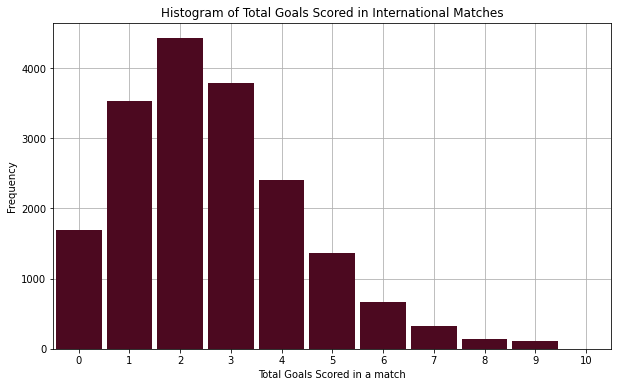

In [277]:
goal_data = pd.read_csv('./clean/clean_EveryInternationalMatch.csv', encoding='ISO-8859-1')
home_games = goal_data[['Home_Team', 'Home Team Goals', 'Away Team Goals']]
home_games['Total Goals'] = home_games['Home Team Goals'] + home_games['Away Team Goals']
home_games = home_games[['Total Goals']]
home_games.hist(bins = range(11), align = 'left', color = '#4c0920', zorder = 2, rwidth = 0.9, figsize = (10, 6))

plt.title('Histogram of Total Goals Scored in International Matches')
plt.xlabel('Total Goals Scored in a match')
plt.ylabel('Frequency')
plt.xticks(range(11))
plt.xlim(-0.5, 10.5)
plt.show()

BRA 5.917388184644822 0.8133460894522841
SMR 0.14965986394557823 4.190476190476191
home 24.796674297559257
away 0.12172526508809695
0 0
home 1.7019279987943643e-11
away 0.8853915830699054
-----
0 1
home 1.7019279987943643e-11
away 0.10777452515595407
-----
0 2
home 1.7019279987943643e-11
away 0.006559441322176141
-----
0 3
home 1.7019279987943643e-11
away 0.00026614991125723593
-----
0 4
home 1.7019279987943643e-11
away 8.099292125240137e-06
-----
0 5
home 1.7019279987943643e-11
away 1.9717769619415872e-07
-----
0 6
home 1.7019279987943643e-11
away 4.000251223115687e-09
-----
1 0
home 4.2202154264000637e-10
away 0.8853915830699054
-----
1 1
home 4.2202154264000637e-10
away 0.10777452515595407
-----
1 2
home 4.2202154264000637e-10
away 0.006559441322176141
-----
1 3
home 4.2202154264000637e-10
away 0.00026614991125723593
-----
1 4
home 4.2202154264000637e-10
away 8.099292125240137e-06
-----
1 5
home 4.2202154264000637e-10
away 1.9717769619415872e-07
-----
1 6
home 4.2202154264000637e-10

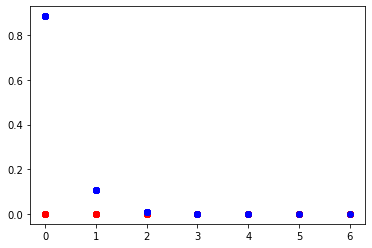

In [289]:
#==============================================================================
# poisson distribution
# source 1: https://fse.studenttheses.ub.rug.nl/21917/1/bMATH_2020_BruinsmaR.pdf
# source 2: https://towardsdatascience.com/predicting-the-fifa-world-cup-2022-with-a-simple-model-using-python-6b34bdd4f2a5
# source 3: https://www.pinnacle.com/en/betting-articles/Soccer/inflating-or-deflating-the-chance-of-a-draw-in-soccer/CGE2JP2SDKV3A9R5
#==============================================================================

def predict_points(home, away):
    if home in team_goal_ratio.index and away in team_goal_ratio.index:
        print(home, team_goal_ratio.at[home,'GoalsScored'], team_goal_ratio.at[home,'GoalsConceded'])
        print(away, team_goal_ratio.at[away,'GoalsScored'], team_goal_ratio.at[away,'GoalsConceded'])
        lamb_home = team_goal_ratio.at[home,'GoalsScored'] * team_goal_ratio.at[away,'GoalsConceded']
        lamb_away = team_goal_ratio.at[away,'GoalsScored'] * team_goal_ratio.at[home,'GoalsConceded']
        print('home', lamb_home)
        print('away', lamb_away)
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,7):
            for y in range(0, 7):
                print(x,y)
                print('home', poisson.pmf(x, lamb_home))
                print('away', poisson.pmf(y, lamb_away))
                #save plot of poisson distribution to image file
                home_plot = poisson.pmf(x, lamb_home)
                away_plot = poisson.pmf(y, lamb_away)
                plt.plot(x, home_plot, 'ro')
                plt.plot(y, away_plot, 'bo')
                print('-----')
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    #upset calculation based on chance and how often the team scores more than the other
                    #shifts odds ever so slightly
                    home_goals_scored = team_goal_ratio.at[home,'GoalsScored']
                    away_goals_scored = team_goal_ratio.at[away,'GoalsScored']
                    max_of_two, min_of_two = max(home_goals_scored, away_goals_scored), min(home_goals_scored, away_goals_scored)
                    is_home_min = home_goals_scored == min_of_two
                    random_draw = rd.uniform(0, max_of_two)
                    if is_home_min:
                        if random_draw < min_of_two:
                            prob_home += p / 2 * rd.uniform(.5, 1.5)
                        else: 
                            prob_away += p / 2 * rd.uniform(.5, 1.5)
                    else:
                        if random_draw < min_of_two:
                            prob_away += p / 2 * rd.uniform(.5, 1.5)
                        else:
                            prob_home += p / 2 * rd.uniform(.5, 1.5)
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                   prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)
print(predict_points('BRA', 'PAN'))

In [279]:
fixtures = pd.read_csv('./fixtures/fifa_worldcup_fixtures.csv')
fixtures = fixtures.iloc[0:]
fixture_group_stage = fixtures[:48].copy()
print(fixture_group_stage)

              home            away  year
0           Qatar          Ecuador  2022
1         Senegal      Netherlands  2022
2           Qatar          Senegal  2022
3     Netherlands          Ecuador  2022
4         Ecuador          Senegal  2022
5     Netherlands            Qatar  2022
6         England             Iran  2022
7   United States            Wales  2022
8           Wales             Iran  2022
9         England    United States  2022
10          Wales          England  2022
11           Iran    United States  2022
12      Argentina     Saudi Arabia  2022
13         Mexico           Poland  2022
14         Poland     Saudi Arabia  2022
15      Argentina           Mexico  2022
16         Poland        Argentina  2022
17   Saudi Arabia           Mexico  2022
18        Denmark          Tunisia  2022
19         France        Australia  2022
20        Tunisia        Australia  2022
21         France          Denmark  2022
22      Australia          Denmark  2022
23        Tunisi

QAT 1.542319749216301 1.0407523510971788
ECU 3.6333333333333333 1.2451851851851852
0 0
home 0.14653753048588775
away 0.02279075724994234
-----
0 1
home 0.14653753048588775
away 0.08618097422789063
-----
0 2
home 0.14653753048588775
away 0.16294237697799932
-----
0 3
home 0.14653753048588775
away 0.20538344611911677
-----
0 4
home 0.14653753048588775
away 0.19415925151929456
-----
0 5
home 0.14653753048588775
away 0.14683876685434133
-----
0 6
home 0.14653753048588775
away 0.09254269061171903
-----
1 0
home 0.2814214737336919
away 0.02279075724994234
-----
1 1
home 0.2814214737336919
away 0.08618097422789063
-----
1 2
home 0.2814214737336919
away 0.16294237697799932
-----
1 3
home 0.2814214737336919
away 0.20538344611911677
-----
1 4
home 0.2814214737336919
away 0.19415925151929456
-----
1 5
home 0.2814214737336919
away 0.14683876685434133
-----
1 6
home 0.2814214737336919
away 0.09254269061171903
-----
2 0
home 0.27023126981817885
away 0.02279075724994234
-----
2 1
home 0.2702312698181

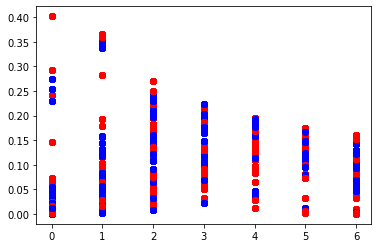

In [280]:
#==============================================================================
# group stage, 48 games, counted by 4 lines in the fixture_group_48
# calculates points for each team in the group stage
#==============================================================================
for index, row in fixture_group_stage.iterrows():
    home = row['home']
    away = row['away']
    home_code = country_code_dict[home.strip()]
    away_code = country_code_dict[away.strip()]
    home_point, away_point = predict_points(home_code, away_code)
    fixture_group_stage.at[index, 'home_point'] = home_point
    fixture_group_stage.at[index, 'away_point'] = away_point
print(fixture_group_stage)
fixture_group_stage.to_csv('./fixtures/fifa_worldcup_fixture_group_48.csv', index=False)


In [281]:
#==============================================================================
# gets the round of 16 teams from the group stage
#==============================================================================

fixture_group_stage = pd.read_csv('./fixtures/fifa_worldcup_fixture_group_48.csv')
fixture_group_stage_48 = fixture_group_stage[0:]

f = open('./fixtures/fifa_worldcup_fixture_group_48_top2.csv', 'w')
header = pd.DataFrame(columns=['home', 'home_point'])
header.to_csv('./fixtures/fifa_worldcup_fixture_group_48_top2.csv', index=False)
for six in range(0, len(fixture_group_stage_48), 6):
    group = fixture_group_stage_48[six:six+6]
    for index, row in group.iterrows():
        group.at[index, 'home'] = row['home'].strip()
        group.at[index, 'away'] = row['away'].strip()
    
    home_games = group.groupby(['home'])['home_point'].sum()
    away_games = group.groupby(['away'])['away_point'].sum()
    group = home_games.add(away_games, fill_value=0)
    group = group.sort_values(ascending=False)
    group = group[:2]
    group.to_csv('./fixtures/fifa_worldcup_fixture_group_48_top2.csv', mode='a', header=False)

f.close()

In [282]:
matches = [["a1", "b2"], ["c1", "d2"], ["e1", "f2"], ["g1", "h2"], ["b1", "a2"], ["d1", "c2"], ["f1", "e2"], ["h1", "g2"]]
match_aligment = {}

In [283]:
#==============================================================================
# create knockout stage matches based on group position - round of 16
#==============================================================================

fixture_group_stage_top2 = pd.read_csv('./fixtures/fifa_worldcup_fixture_group_48_top2.csv')
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
current_number = 1
current_letter = 0
for i in range(0, len(fixture_group_stage_top2)):
    country = fixture_group_stage_top2.iloc[i, 0]
    match_aligment[alphabet[current_letter]+str(current_number)] = country
    if current_number == 1: current_number = 2
    else: 
        current_number = 1
        current_letter += 1

In [284]:
#==============================================================================
# SIDE EFFECT METHOD: adds winner to specified list to implement reusability
#==============================================================================
def winner(stored: list(), one, two):
    country_one_code = country_code_dict[one.strip()]
    country_two_code = country_code_dict[two.strip()]
    country_one_points, country_two_points = predict_points(country_one_code, country_two_code)
    if country_one_points > country_two_points: stored.append(one)
    else: stored.append(two)

SEN 4.262093495934959 0.9231707317073171
WAL 1.105263157894737 1.1435406698564594
0 0
home 0.007643671324787907
away 0.36046998027155636
-----
0 1
home 0.007643671324787907
away 0.3678043181243217
-----
0 2
home 0.007643671324787907
away 0.18764394240123053
-----
0 3
home 0.007643671324787907
away 0.06382061943415408
-----
0 4
home 0.007643671324787907
away 0.016279787983709052
-----
0 5
home 0.007643671324787907
away 0.0033222052577281513
-----
0 6
home 0.007643671324787907
away 0.000564966805542409
-----
1 0
home 0.03725431578654497
away 0.36046998027155636
-----
1 1
home 0.03725431578654497
away 0.3678043181243217
-----
1 2
home 0.03725431578654497
away 0.18764394240123053
-----
1 3
home 0.03725431578654497
away 0.06382061943415408
-----
1 4
home 0.03725431578654497
away 0.016279787983709052
-----
1 5
home 0.03725431578654497
away 0.0033222052577281513
-----
1 6
home 0.03725431578654497
away 0.000564966805542409
-----
2 0
home 0.09078648111299607
away 0.36046998027155636
-----
2 1
h

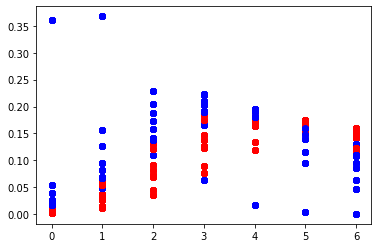

In [285]:
#==============================================================================
# calculate knockout stage winners, -> 8 winners
#==============================================================================

winners = []
for match in matches:
    country_one = match_aligment[match[0]]
    country_two = match_aligment[match[1]]
    winner(winners, country_one, country_two)
print(winners)

file = open('./fixtures/fifa_worldcup_fixture_knockout.csv', 'w')
writer = csv.writer(file)
writer.writerow(winners)
file.close()

SEN 4.262093495934959 0.9231707317073171
ARG 4.808561967833491 0.9062440870387891
0 0
home 0.021015457741684427
away 0.011806280181649824
-----
0 1
home 0.021015457741684427
away 0.052409537812612414
-----
0 2
home 0.021015457741684427
away 0.11632620992685165
-----
0 3
home 0.021015457741684427
away 0.1721288106543783
-----
0 4
home 0.021015457741684427
away 0.19102526942931675
-----
0 5
home 0.021015457741684427
away 0.16959695903000716
-----
0 6
home 0.021015457741684427
away 0.1254769792069703
-----
1 0
home 0.08117214309238097
away 0.011806280181649824
-----
1 1
home 0.08117214309238097
away 0.052409537812612414
-----
1 2
home 0.08117214309238097
away 0.11632620992685165
-----
1 3
home 0.08117214309238097
away 0.1721288106543783
-----
1 4
home 0.08117214309238097
away 0.19102526942931675
-----
1 5
home 0.08117214309238097
away 0.16959695903000716
-----
1 6
home 0.08117214309238097
away 0.1254769792069703
-----
2 0
home 0.15676358076990088
away 0.011806280181649824
-----
2 1
home 0

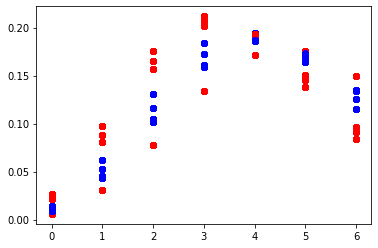

In [286]:
#==============================================================================
# calculate semi final winners, -> 4 winners
#==============================================================================

knockout_fixtures = pd.read_csv('./fixtures/fifa_worldcup_fixture_knockout.csv')

knockout_matches = [[1,2], [3,4], [5,6], [7,8]]
knockout_winners = []

for m in knockout_matches:
    country_one = knockout_fixtures.columns[m[0]-1]
    country_two = knockout_fixtures.columns[m[1]-1]
    winner(knockout_winners, country_one, country_two)
print(knockout_winners)

ARG 4.808561967833491 0.9062440870387891
BRA 5.917388184644822 0.8133460894522841
0 0
home 0.020019968622052218
away 0.004688708755688674
-----
0 1
home 0.020019968622052218
away 0.025143660444563155
-----
0 2
home 0.020019968622052218
away 0.0674176722732517
-----
0 3
home 0.020019968622052218
away 0.12051129269117943
-----
0 4
home 0.020019968622052218
away 0.16156340588899099
-----
0 5
home 0.020019968622052218
away 0.17327992117280724
-----
0 6
home 0.020019968622052218
away 0.15487176131892189
-----
1 0
home 0.07829859923003504
away 0.004688708755688674
-----
1 1
home 0.07829859923003504
away 0.025143660444563155
-----
1 2
home 0.07829859923003504
away 0.0674176722732517
-----
1 3
home 0.07829859923003504
away 0.12051129269117943
-----
1 4
home 0.07829859923003504
away 0.16156340588899099
-----
1 5
home 0.07829859923003504
away 0.17327992117280724
-----
1 6
home 0.07829859923003504
away 0.15487176131892189
-----
2 0
home 0.15311389236226472
away 0.004688708755688674
-----
2 1
home

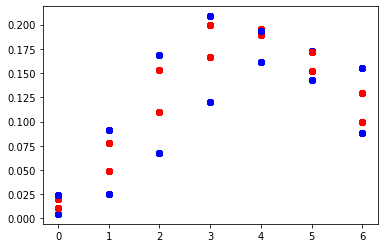

In [287]:
#==============================================================================
# calculate semi final winners, -> 2 winners
#==============================================================================

semi_final_matches = [[1,2], [3,4]]
semi_final_winners = []
for m in semi_final_matches:
    country_one = knockout_winners[m[0]-1]
    country_two = knockout_winners[m[1]-1]
    winner(semi_final_winners, country_one, country_two)
print(semi_final_winners)

BRA 5.917388184644822 0.8133460894522841
FRA 5.121212121212121 0.7191222570532916
0 0
home 0.014188470976611205
away 0.015524779532889117
-----
0 1
home 0.014188470976611205
away 0.06466564133738284
-----
0 2
home 0.014188470976611205
away 0.1346764751382219
-----
0 3
home 0.014188470976611205
away 0.18699010871451008
-----
0 4
home 0.014188470976611205
away 0.19471830949602664
-----
0 5
home 0.014188470976611205
away 0.16221273013270693
-----
0 6
home 0.014188470976611205
away 0.11261126344174674
-----
1 0
home 0.0603765630225115
away 0.015524779532889117
-----
1 1
home 0.0603765630225115
away 0.06466564133738284
-----
1 2
home 0.0603765630225115
away 0.1346764751382219
-----
1 3
home 0.0603765630225115
away 0.18699010871451008
-----
1 4
home 0.0603765630225115
away 0.19471830949602664
-----
1 5
home 0.0603765630225115
away 0.16221273013270693
-----
1 6
home 0.0603765630225115
away 0.11261126344174674
-----
2 0
home 0.12846096554098038
away 0.015524779532889117
-----
2 1
home 0.128460

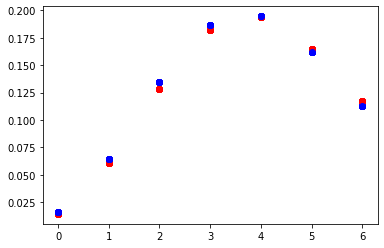

In [288]:
country_one_code = country_code_dict[semi_final_winners[0].strip()]
country_two_code = country_code_dict[semi_final_winners[1].strip()]
country_one_point, country_two_point = predict_points(country_one_code, country_two_code)
if country_one_point > country_two_point: print(semi_final_winners[0], "wins the world cup!")
else: print(semi_final_winners[1], "wins the world cup!")
